In [22]:
import torch
import torch.nn as nn
import numpy as np
from torch.nn.utils import clip_grad_norm_
from data_utils import Dictionary, Corpus

In [23]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
# Hyper-parameters
embed_size = 128
hidden_size = 1024
num_layers = 1
num_epochs = 5
num_samples = 1000     # number of words to be sampled
batch_size = 20
seq_length = 30
learning_rate = 0.002
tanh = True
Adam = True
dropout = False

In [25]:
actFunc = "tanh" if tanh else "ReLU"
opt = "Adam" if Adam else "SGD"
d_out = "Yes" if dropout else "No"
title = "LSTM-L-"+str(num_layers) + "-H-" + str(hidden_size) + "-Dropout-" + d_out + "-" + actFunc + "-" + opt 

In [26]:
title

'LSTM(L: 1, H: 2048, D: No, tanh, Adam)'

In [27]:
# Load "Penn Treebank" dataset
corpus = Corpus()
ids = corpus.get_data('data/cookbook.txt', batch_size)
vocab_size = len(corpus.dictionary)
num_batches = ids.size(1) // seq_length

In [28]:
# RNN based language model
class RNNLM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = None
        if dropout:
            self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout = 0.5, batch_first=True)
        else:
            self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, h):
        # Embed word ids to vectors
        x = self.embed(x)
        
        # Forward propagate LSTM
        out, (h, c) = self.lstm(x, h)
        
        # Reshape output to (batch_size*sequence_length, hidden_size)
        out = out.reshape(out.size(0)*out.size(1), out.size(2))
        
        # Decode hidden states of all time steps
        out = self.linear(out)
        return out, (h, c)

In [29]:
model = RNNLM(vocab_size, embed_size, hidden_size, num_layers).to(device)

In [30]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
# Truncated backpropagation
def detach(states):
    return [state.detach() for state in states] 

In [32]:
%%time
print('ok')

ok
CPU times: user 0 ns, sys: 273 µs, total: 273 µs
Wall time: 243 µs


In [33]:
%%time
# Train the model
loss_ot = []
for epoch in range(num_epochs):
    # Set initial hidden and cell states
    states = (torch.zeros(num_layers, batch_size, hidden_size).to(device),
              torch.zeros(num_layers, batch_size, hidden_size).to(device))
    
    for i in range(0, ids.size(1) - seq_length, seq_length):
        # Get mini-batch inputs and targets
        inputs = ids[:, i:i+seq_length].to(device)
        targets = ids[:, (i+1):(i+1)+seq_length].to(device)
        
        # Forward pass
        states = detach(states)
        outputs, states = model(inputs, states)
        loss = criterion(outputs, targets.reshape(-1))
        loss_ot.append(loss.item())
        
        # Backward and optimize
        model.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        step = (i+1) // seq_length
        if step % 100 == 0:
            print ('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
                   .format(epoch+1, num_epochs, step, num_batches, loss.item(), np.exp(loss.item())))

Epoch [1/5], Step[0/165], Loss: 8.3918, Perplexity: 4410.61
Epoch [1/5], Step[100/165], Loss: 3.1399, Perplexity: 23.10
Epoch [2/5], Step[0/165], Loss: 3.0136, Perplexity: 20.36
Epoch [2/5], Step[100/165], Loss: 2.1417, Perplexity:  8.51
Epoch [3/5], Step[0/165], Loss: 2.2987, Perplexity:  9.96
Epoch [3/5], Step[100/165], Loss: 1.5551, Perplexity:  4.74
Epoch [4/5], Step[0/165], Loss: 1.6102, Perplexity:  5.00
Epoch [4/5], Step[100/165], Loss: 1.1686, Perplexity:  3.22
Epoch [5/5], Step[0/165], Loss: 1.1717, Perplexity:  3.23
Epoch [5/5], Step[100/165], Loss: 0.9305, Perplexity:  2.54
CPU times: user 17.3 s, sys: 6.35 s, total: 23.7 s
Wall time: 23.6 s


In [34]:
import matplotlib.pyplot as plt

In [35]:
model

RNNLM(
  (embed): Embedding(4389, 128)
  (lstm): LSTM(128, 2048, batch_first=True)
  (linear): Linear(in_features=2048, out_features=4389, bias=True)
)

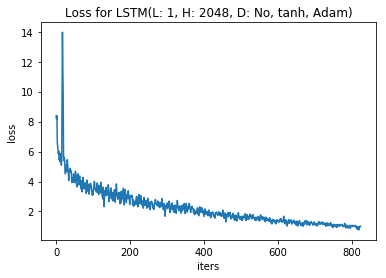

In [36]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.title("Loss for " + title)
plt.plot(loss_ot)
plt.show()

In [57]:
plt.savefig("imgs/" + title, dpi=420)

<Figure size 432x288 with 0 Axes>

In [56]:
with open("metrics/" + title + ".txt", 'w') as f:
    f.write("Loss: " + str(loss_ot[-1]) + "\n")
    f.write("Perplexity: " + str(np.exp(loss_ot[-1])) + "\n")
f.close()

In [58]:
# Test the model
with torch.no_grad():
    with open(title, 'w') as f:
        # Set intial hidden ane cell states
        state = (torch.zeros(num_layers, 1, hidden_size).to(device),
                 torch.zeros(num_layers, 1, hidden_size).to(device))

        # Select one word id randomly
        prob = torch.ones(vocab_size)
        input = torch.multinomial(prob, num_samples=1).unsqueeze(1).to(device)

        for i in range(num_samples):
            # Forward propagate RNN 
            output, state = model(input, state)

            # Sample a word id
            prob = output.exp()
            word_id = torch.multinomial(prob, num_samples=1).item()

            # Fill input with sampled word id for the next time step
            input.fill_(word_id)

            # File write
            word = corpus.dictionary.idx2word[word_id]
            word = '\n' if word == '<eos>' else word + ' '
            f.write(word)

            if (i+1) % 100 == 0:
                print('Sampled [{}/{}] words and save to {}'.format(i+1, num_samples, "outputs/" + title + '.txt'))

# Save the model checkpoints
# torch.save(model.state_dict(), 'saved_models/' + title + '.ckpt')

Sampled [100/1000] words and save to sample.txt
Sampled [200/1000] words and save to sample.txt
Sampled [300/1000] words and save to sample.txt
Sampled [400/1000] words and save to sample.txt
Sampled [500/1000] words and save to sample.txt
Sampled [600/1000] words and save to sample.txt
Sampled [700/1000] words and save to sample.txt
Sampled [800/1000] words and save to sample.txt
Sampled [900/1000] words and save to sample.txt
Sampled [1000/1000] words and save to sample.txt
